In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from utils.evaluate_basset_performance import *

In [3]:
data_dir = "/clusterfs/nilah/pooja/kidney_data"
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures"

targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", header=0, index_col=0)
cell_types = targets["identifier"].values

cell_type_peak_set_mapping = {"PT": ["cluster11_PT", "cluster3_Ubiquitous", "all_sequences"],
                              "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"],
                              "LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"],
                              "Str": ["cluster9_Stroma", "cluster3_Ubiquitous", "all_sequences"],}


tasks = ["single_task", "multitask", "multitask_8x_params_same_layers"]
training_sets = ["all_sequences", "1_1_peaks_non_peaks", "1_1_gc_matched",
                 "remove_non_peaks", "remove_non_peaks_ubiq_peaks"]

### Read in data

In [4]:
# reference accuracy
ref_acc_by_cluster_replicates = read_reference_accuracy_replicates(data_dir, cell_type_peak_set_mapping.keys(), 
                                                                   tasks, training_sets)
formatted_df = format_df_to_plot(ref_acc_by_cluster_replicates, cell_type_peak_set_mapping,
                                 tasks, training_sets)
formatted_df.loc[~formatted_df["Cluster"].isin(['cluster3_Ubiquitous', 'all_sequences']), 
                 "Cluster"] = "Cell-type specific"



In [11]:
# allelic imbalance accuracy
cell_type_peak_set_mapping = {"PT": ["cluster11_PT_matched", "cluster3_Ubiquitous_matched"],
                              "DT": ["cluster4_DistalNephron_matched", "cluster3_Ubiquitous_matched"],
                              "LOH": ["cluster4_DistalNephron_matched", "cluster3_Ubiquitous_matched"],
                              "Str": ["cluster9_Stroma_matched", "cluster3_Ubiquitous_matched"]}

allelic_imbalance_by_cluster_replicates = read_imbalance_accuracy_replicates(data_dir,
                                                                             cell_type_peak_set_mapping.keys(),
                                                                             tasks, training_sets)
allelic_imbalance_formatted_df = format_df_to_plot(allelic_imbalance_by_cluster_replicates, 
                                                   cell_type_peak_set_mapping,
                                                   tasks, training_sets)
allelic_imbalance_formatted_df.loc[~allelic_imbalance_formatted_df["Cluster"].isin(['cluster3_Ubiquitous_matched']), 
                                   "Cluster"] = "Cell-type specific"

In [14]:
# cross cell type correlations
targets_dir = f"{data_dir}/CellTypeSpecificPeakClusters_ArchR_clust11/model_predictions"
models_dir = f"{data_dir}/train/replicate_models"
multitask_model = f"{models_dir}/train__multitask__all_sequences__1"
multitask_high_capacity_model = f"{models_dir}/train__multitask_8x_params_same_layers__all_sequences__1"
single_task_model = models_dir + "/train__single_task__{cell_type}__all_sequences__1"


cell_type_peak_set_mapping = {"PT": ["cluster11_PT", "cluster3_Ubiquitous"],
                             "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                             "LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous"],
                             "Str": ["cluster9_Stroma", "cluster3_Ubiquitous"]}
replicates = ["200131", "200317", "200707"]


model_preds = {"Multi-task predictions": read_multi_task_targets_predictions(multitask_model, 
                                                                 targets_dir,
                            np.unique(np.concatenate(list(cell_type_peak_set_mapping.values()))), 
                                                                 cell_types),
               "Multi-task (8x params) predictions": read_multi_task_targets_predictions(multitask_high_capacity_model, 
                                                                 targets_dir,
                            np.unique(np.concatenate(list(cell_type_peak_set_mapping.values()))), 
                                                                 cell_types),
               "Single-task predictions": read_single_task_targets_predictions(single_task_model,
                                                                   targets_dir,
                            np.unique(np.concatenate(list(cell_type_peak_set_mapping.values()))), 
                                                                    cell_type_peak_set_mapping.keys())}

cross_cell_type_correlations = compute_cross_cell_type_correlations(model_preds, 
                                                                    cell_type_peak_set_mapping, 
                                                                    "cluster3_Ubiquitous")

biological_rep_data = read_biological_replicate_data(targets_dir, 
                                                   np.unique(np.concatenate(list(cell_type_peak_set_mapping.values()))),
                                                   cell_types,
                                                   replicates)
biological_rep_correlations = compute_biological_replicate_correlations(biological_rep_data,
                                                                        cell_type_peak_set_mapping,
                                                                        replicates, "cluster3_Ubiquitous")

### Fig 3C -- Cell-type specific vs ubiquitous

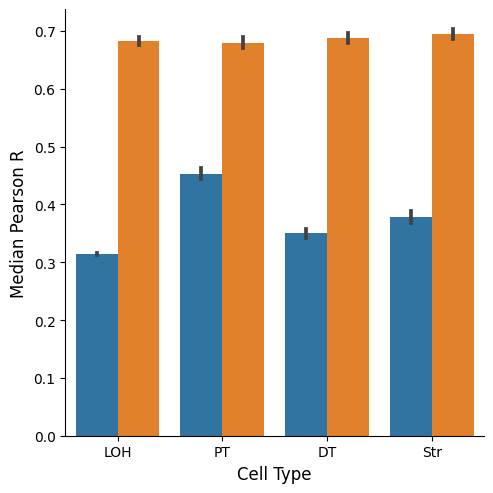

In [10]:
sns.catplot(data=formatted_df[(formatted_df["Training Data"] == "all_sequences") &
                              (formatted_df["Training Task"] == "multitask") &
                              (formatted_df["Cluster"].isin(["cluster3_Ubiquitous", "Cell-type specific"]))],
            x="Cell Type", y="Pearson R", hue="Cluster", 
            hue_order=["Cell-type specific", "cluster3_Ubiquitous"],
            order=["LOH", "PT", "DT", "Str"],
            kind="bar", palette="tab10", estimator=np.median, ci="sd", legend=False)
plt.ylabel("Median Pearson R" ,fontsize=12)
plt.xlabel("Cell Type" ,fontsize=12)
plt.savefig(f"{fig_dir}/fig3/loeb_et_al_cell_type_specific_ubiquitous_barplot_median.pdf", dpi=300)

### Fig 4A -- Single task vs multitask

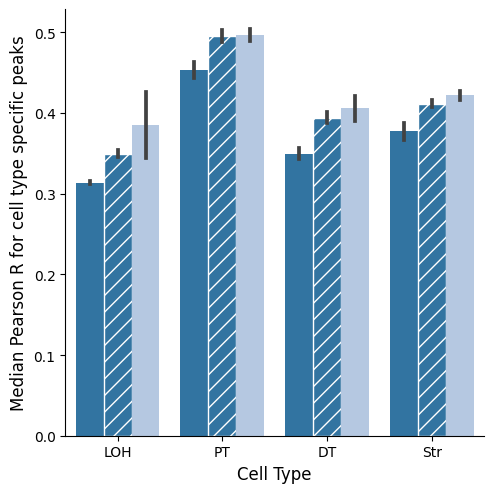

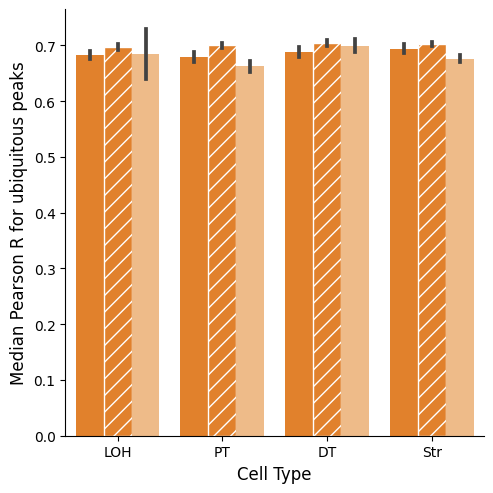

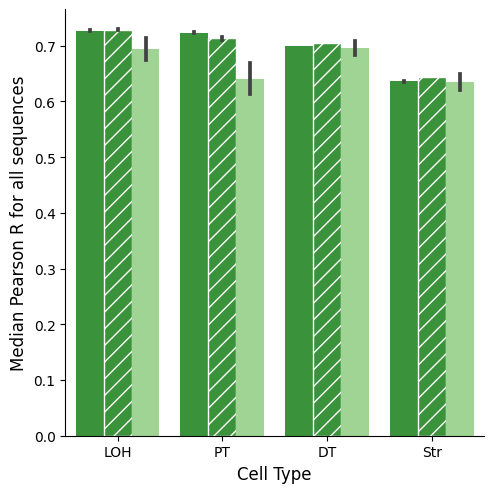

In [11]:
cmap = plt.get_cmap("tab20")
cluster_labels = ["cell type specific peaks", "ubiquitous peaks", "all sequences"]
for i, cluster in enumerate(["Cell-type specific",  "cluster3_Ubiquitous", "all_sequences"]):
    g = sns.catplot(data=formatted_df[(formatted_df["Training Data"] == "all_sequences") &
                                  (formatted_df["Cluster"] == cluster)],
                x="Cell Type", y="Pearson R", hue="Training Task", 
                hue_order=["multitask", "multitask_8x_params_same_layers", "single_task"],
                order=["LOH", "PT", "DT", "Str"],
                kind="bar", estimator=np.median, ci="sd", palette=[cmap(2*i), cmap(2*i), cmap(2*i+1)],
                legend=False)
    for p in range(4, 8):
        g.axes[0][0].patches[p].set_hatch('//')
        g.axes[0][0].patches[p].set_edgecolor("white")
        
    plt.ylabel(f"Median Pearson R for {cluster_labels[i]}" ,fontsize=12)
    plt.xlabel("Cell Type" ,fontsize=12)
    plt.savefig(f"{fig_dir}/fig4/loeb_et_al_{cluster}_single_multi_task_high_capacity_barplot_median.pdf", dpi=300)

### Fig 4B -- Cross cell type correlations

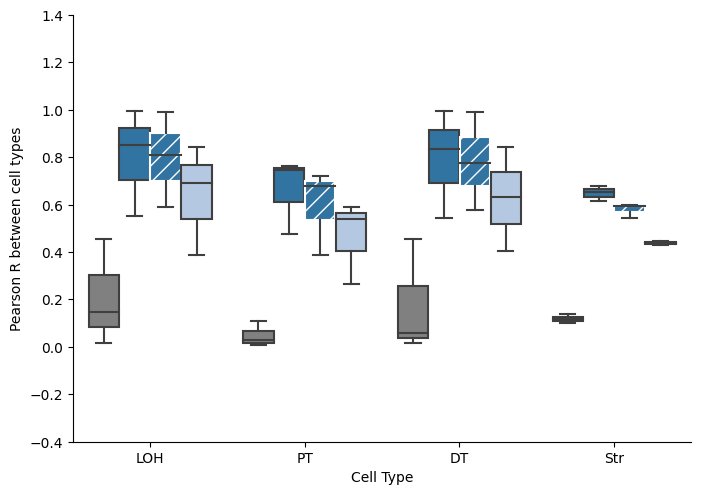

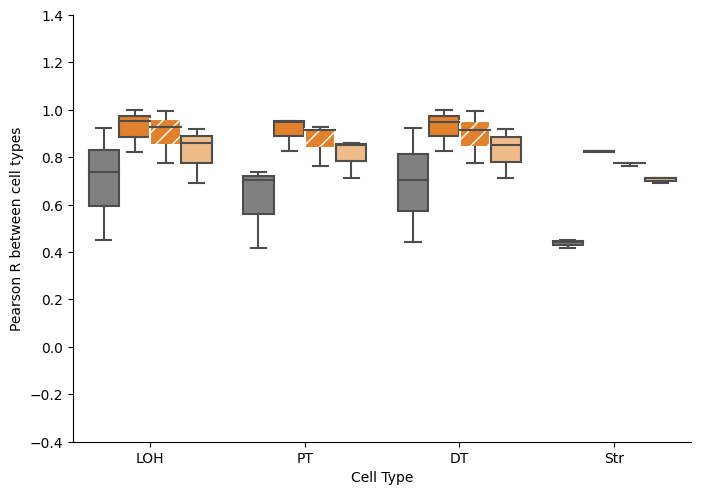

In [40]:
cross_cell_type_correlations = pd.concat([cross_cell_type_correlations, biological_rep_correlations])

cmap = plt.get_cmap("tab20")

for i, cluster in enumerate(cross_cell_type_correlations["Cluster"].unique()):

    palette={"Measurement": "gray", 
             "Cross-individual measurement correlation (same cell type)": "lightgray",
             "Cross-individual measurement correlation (different cell types)": "white",
             "Multi-task predictions": cmap(2*i), 
             "Multi-task (8x params) predictions": cmap(2*i),
             "Single-task predictions": cmap(2*i+1)}
    
    g = sns.catplot(data=cross_cell_type_correlations[cross_cell_type_correlations["Cluster"] == cluster], 
                   x="Cell Type", y="log-log Pearson R", hue="Training task", 
                   order=["LOH", "PT", "DT", "Str"],
                   hue_order=["Measurement", 
                              # "Cross-individual measurement correlation (same cell type)",
                              "Multi-task predictions", "Multi-task (8x params) predictions", 
                              "Single-task predictions"],
                   palette=palette, kind="box", aspect=1.4, legend=False)
 
    for j in [4, 5, 10, 14, 18]:
        g.axes[0][0].patches[j].set_hatch('//')
        g.axes[0][0].patches[j].set_edgecolor("white")

        
    # plt.legend(loc=(1.01,0))
    plt.ylabel("Pearson R between cell types")
    plt.ylim(-0.4, 1.4)
    sns.despine()
    plt.savefig(f"{fig_dir}/fig4/loeb_et_al_{cluster}_single_multi_task_high_capacity_cross_cell_type_correlations_boxplot.pdf",
                dpi=300)

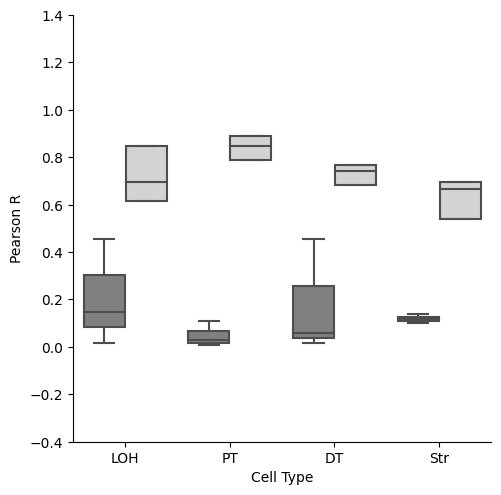

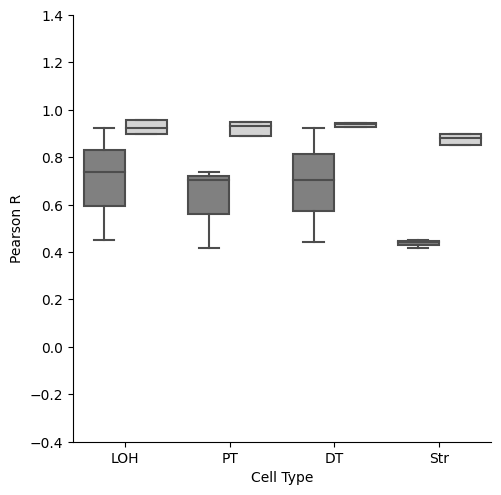

In [39]:
cross_cell_type_correlations = pd.concat([cross_cell_type_correlations, biological_rep_correlations])

cmap = plt.get_cmap("tab20")

for i, cluster in enumerate(cross_cell_type_correlations["Cluster"].unique()):

    palette={"Measurement": "gray", 
             "Cross-individual measurement correlation (same cell type)": "lightgray",
             "Cross-individual measurement correlation (different cell types)": "white"}
    
    g = sns.catplot(data=cross_cell_type_correlations[cross_cell_type_correlations["Cluster"] == cluster], 
                   x="Cell Type", y="log-log Pearson R", hue="Training task", 
                   order=["LOH", "PT", "DT", "Str"],
                   hue_order=["Measurement", 
                              "Cross-individual measurement correlation (same cell type)"],
                   palette=palette, kind="box", aspect=1, legend=False)
    # plt.legend(loc=(1.01,0))
    plt.ylabel("Pearson R")
    plt.ylim(-0.4, 1.4)
    sns.despine()
    plt.savefig(f"{fig_dir}/fig4/loeb_et_al_{cluster}_cross_indv_corr_boxplot.pdf",
                dpi=300)

### Supplemental figures

Reference accuracy for different training sets

/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.6823529411764706, 0.7803921568627451, 0.9098039215686274)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.7333333333333333, 0.47058823529411764)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.7803921568627451, 0.7803921568627451, 0.7803921568627451)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This

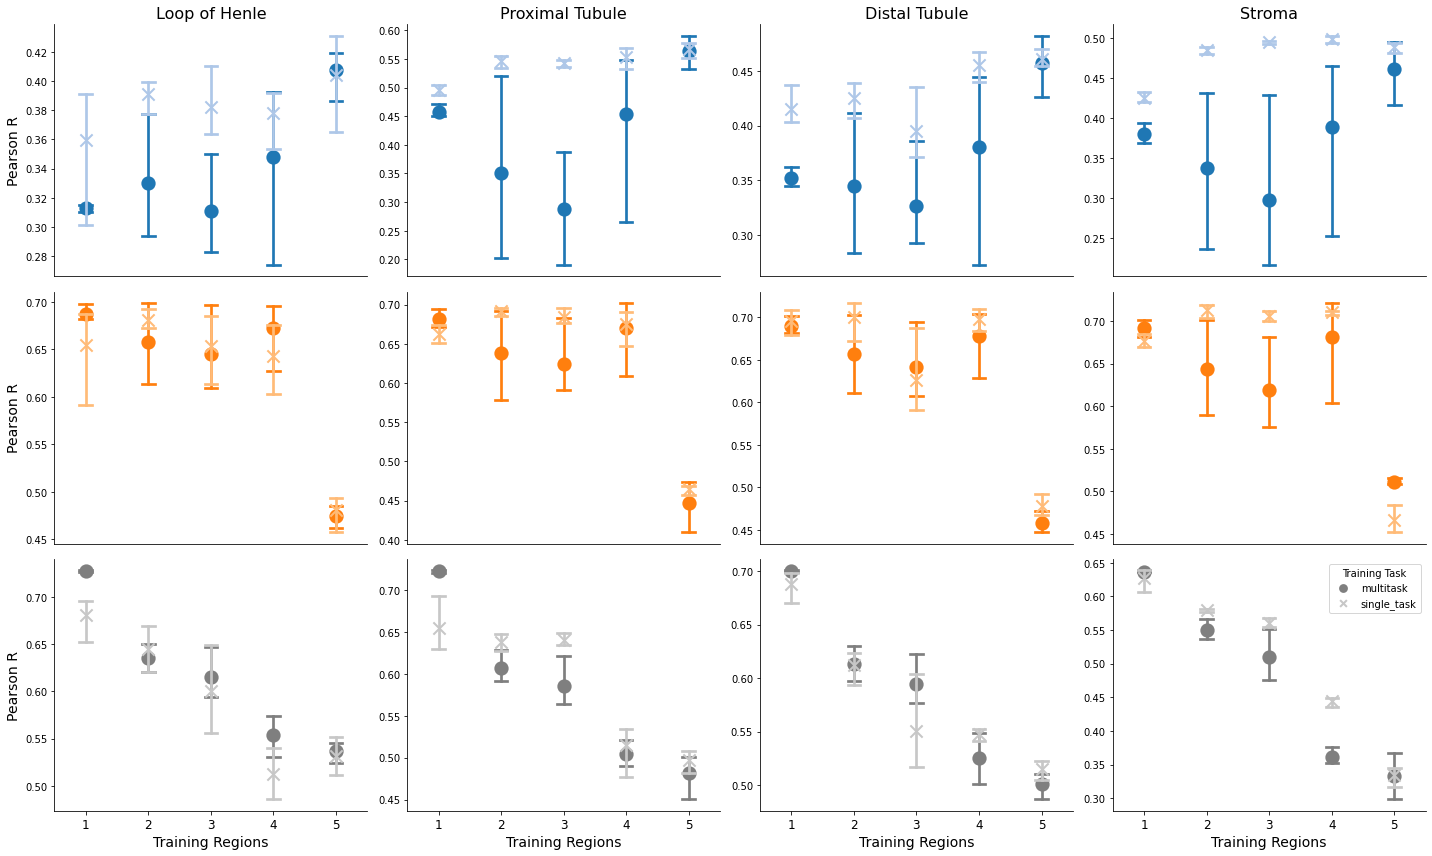

In [13]:
cmap = plt.get_cmap("tab20")
cell_types = ["Loop of Henle", "Proximal Tubule", "Distal Tubule", "Stroma"]
colors = [[cmap(0), cmap(1)], [cmap(2), cmap(3)], [cmap(14), cmap(15)]]

fig, ax = plt.subplots(3, len(formatted_df["Cell Type"].unique()), figsize=(20, 12))
for i, cell_type in enumerate(["LOH", "PT", "DT", "Str"]):
    for j, cluster in enumerate(['Cell-type specific', 'cluster3_Ubiquitous', 'all_sequences']):
        g = sns.pointplot(data=formatted_df[(formatted_df["Cell Type"] == cell_type) & 
                                            (formatted_df["Cluster"] == cluster) ], 
                    x="Training Data", y="Pearson R", hue="Training Task",
                    hue_order=["multitask", "single_task"],
                    height=5, aspect=1.3,
                    capsize=0.2, errorbar="se", kind="point",
                    palette=colors[j], markers=['o', 'x'], s=100,
                    join=False,
                    ax=ax[j, i], legend=False)

        ax[j,i].collections[0].set_sizes([150])
        ax[j,i].collections[1].set_sizes([150])
    
    
        if i == 0:
            ax[j,i].set_ylabel("Pearson R", fontsize=14)
        else:
            ax[j,i].set_ylabel("")
        
        if j == 0:
            ax[j,i].set_title(cell_types[i], fontsize=16)
            
        if j == 2:
            ax[j,i].set_xticklabels(np.arange(1, 6), fontsize=12)
            ax[j,i].set_xlabel("Training Regions", fontsize=14)
        else:
            ax[j,i].set_xticks([])
            ax[j,i].set_xlabel("")
            
        if i != 3 or j != 2:
            ax[j,i].get_legend().set_visible(False)
                               

sns.despine()
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_training_set_reference_accuracy_comparison.pdf",
                dpi=300)

Allelic imbalance accuracy

/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.6823529411764706, 0.7803921568627451, 0.9098039215686274)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.7333333333333333, 0.47058823529411764)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.6823529411764706, 0.7803921568627451, 0.9098039215686274)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This

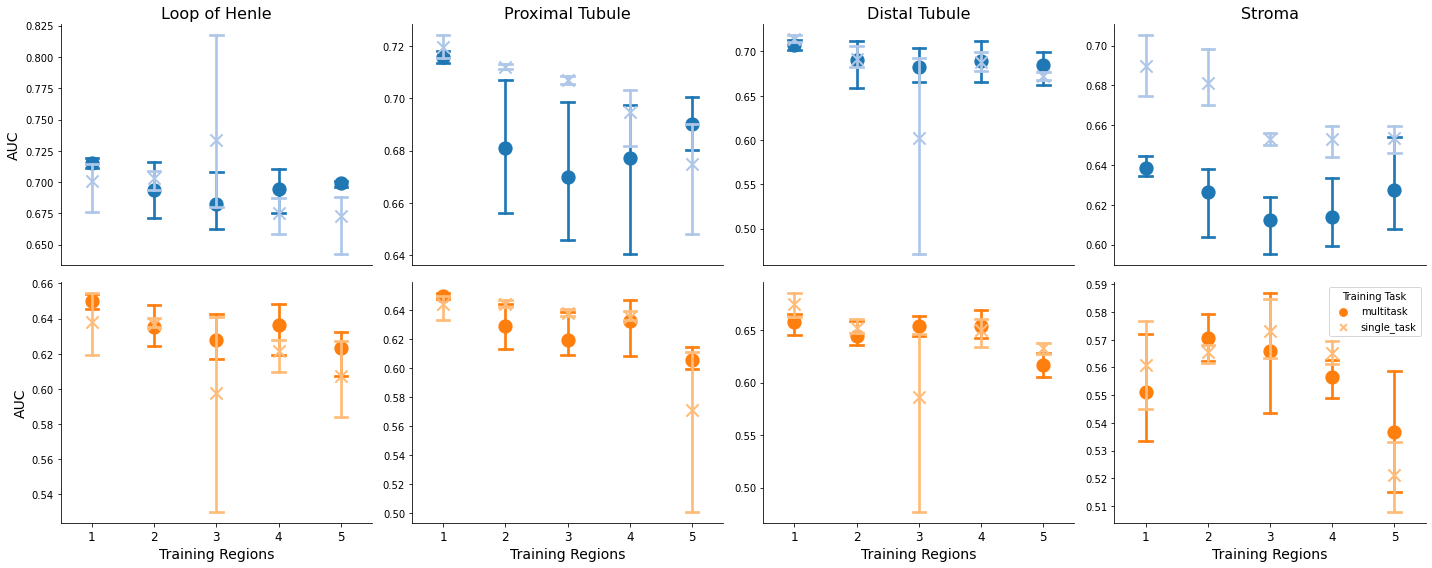

In [14]:
cmap = plt.get_cmap("tab20")
cell_types = ["Loop of Henle", "Proximal Tubule", "Distal Tubule", "Stroma"]
colors = [[cmap(0), cmap(1)], [cmap(2), cmap(3)], [cmap(14), cmap(15)]]

fig, ax = plt.subplots(2, len(formatted_df["Cell Type"].unique()), figsize=(20, 8))
for i, cell_type in enumerate(["LOH", "PT", "DT", "Str"]):
    for j, cluster in enumerate(['Cell-type specific', 'cluster3_Ubiquitous_matched']):
        g = sns.pointplot(data=allelic_imbalance_formatted_df[(allelic_imbalance_formatted_df["Cell Type"] == cell_type) & 
                                            (allelic_imbalance_formatted_df["Cluster"] == cluster) ], 
                    x="Training Data", y="Pearson R", hue="Training Task",
                    hue_order=["multitask", "single_task"],
                    height=5, aspect=1.3,
                    capsize=0.2, errorbar="se", kind="point",
                    palette=colors[j], markers=['o', 'x',], s=100,
                    join=False,
                    ax=ax[j, i], legend=False)
        ax[j,i].collections[0].set_sizes([150])
        ax[j,i].collections[1].set_sizes([150])
    
    
        if i == 0:
            ax[j,i].set_ylabel("AUC", fontsize=14)
        else:
            ax[j,i].set_ylabel("")
        
        if j == 0:
            ax[j,i].set_title(cell_types[i], fontsize=16)
            
        if j == 1:
            ax[j,i].set_xticklabels(np.arange(1, 6), fontsize=12)
            ax[j,i].set_xlabel("Training Regions", fontsize=14)
        else:
            ax[j,i].set_xticks([])
            ax[j,i].set_xlabel("")
                               
        if i != 3 or j != 1:
            ax[j,i].get_legend().set_visible(False)
sns.despine()
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_training_set_allelic_imbalance_comparison.pdf",
                dpi=300)

/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.6823529411764706, 0.7803921568627451, 0.9098039215686274)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.7333333333333333, 0.47058823529411764)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/global/home/users/poojakathail/.local/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.6823529411764706, 0.7803921568627451, 0.9098039215686274)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This

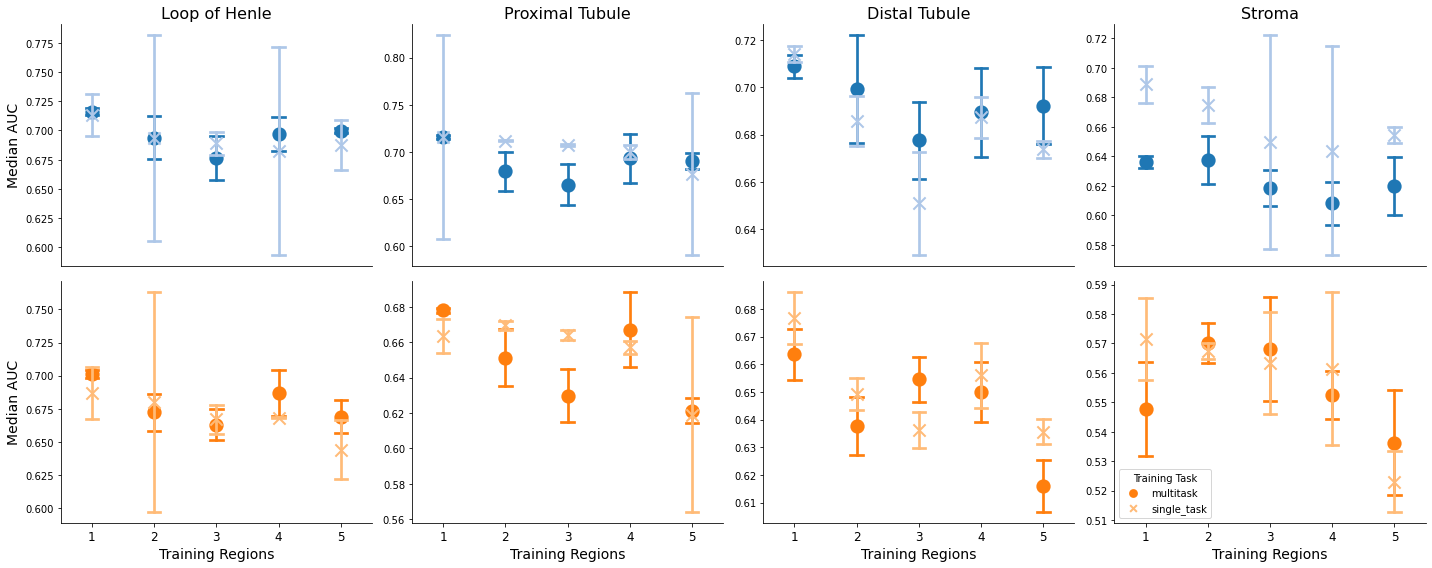

In [23]:
cmap = plt.get_cmap("tab20")
cell_types = ["Loop of Henle", "Proximal Tubule", "Distal Tubule", "Stroma"]
colors = [[cmap(0), cmap(1)], [cmap(2), cmap(3)], [cmap(14), cmap(15)]]

fig, ax = plt.subplots(2, len(formatted_df["Cell Type"].unique()), figsize=(20, 8))
for i, cell_type in enumerate(["LOH", "PT", "DT", "Str"]):
    for j, cluster in enumerate(['Cell-type specific', 'cluster3_Ubiquitous_matched']):
        g = sns.pointplot(data=allelic_imbalance_formatted_df[(allelic_imbalance_formatted_df["Cell Type"] == cell_type) & 
                                            (allelic_imbalance_formatted_df["Cluster"] == cluster) ], 
                    x="Training Data", y="Pearson R", hue="Training Task",
                    hue_order=["multitask", "single_task"],
                    height=5, aspect=1.3,
                    capsize=0.2, estimator=np.median, ci="sd", kind="point",
                    palette=colors[j], markers=['o', 'x',], s=100,
                    join=False,
                    ax=ax[j, i], legend=False)
        ax[j,i].collections[0].set_sizes([150])
        ax[j,i].collections[1].set_sizes([150])
    
    
        if i == 0:
            ax[j,i].set_ylabel("Median AUC", fontsize=14)
        else:
            ax[j,i].set_ylabel("")
        
        if j == 0:
            ax[j,i].set_title(cell_types[i], fontsize=16)
            
        if j == 1:
            ax[j,i].set_xticklabels(np.arange(1, 6), fontsize=12)
            ax[j,i].set_xlabel("Training Regions", fontsize=14)
        else:
            ax[j,i].set_xticks([])
            ax[j,i].set_xlabel("")
                               
        if i != 3 or j != 1:
            ax[j,i].get_legend().set_visible(False)
sns.despine()
plt.tight_layout()
plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_training_set_allelic_imbalance_comparison.pdf",
                dpi=300)